In [3]:
import torch
import matplotlib.pyplot as plt

classes = sorted(["baseball", "basketball", "football", "golf", "hockey", "rugby", "swimming", "tennis", "volleyball", "weightlifting"])

def unnormalize(image):
	mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
	std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
	return image * std + mean

def saliency_map(model, input_image):
	model.eval()

	input_image = input_image.clone().detach().requires_grad_(True)
	model.zero_grad()

	output = model(input_image.unsqueeze(0))

	target_class = output.argmax(dim=1)
	target_score = output[0, target_class]

	target_score.backward()

	sal = input_image.grad.data.abs().squeeze()

	if sal.dim() == 3:
		sal, _ = sal.max(dim=0)

	sal = sal / (sal.max() + 1e-5)

	return sal.cpu()

class GradCAM:
	def __init__(self, model, target_layer):
		self.model = model.eval()
		self.target_layer = target_layer

		self.gradients = None
		self.activations = None

		def forward_hook(module, input, output):
			self.activations = output.detach()

		def backward_hook(module, grad_input, grad_output):
			self.gradients = grad_output[0].detach()

		target_layer.register_forward_hook(forward_hook)
		target_layer.register_full_backward_hook(backward_hook)

	def __call__(self, input_tensor, target_class=None):
		self.model.zero_grad()

		output = self.model(input_tensor.unsqueeze(0))

		if target_class is None:
			target_class = output.argmax(dim=1).item()

		loss = output[0, target_class]
		loss.backward()

		gradients = self.gradients.squeeze(0)
		activations = self.activations.squeeze(0)

		weights = gradients.mean(dim=(1, 2), keepdim=True)

		cam = (weights * activations).sum(dim=0)
		cam = torch.relu(cam)
		cam -= cam.min()
		cam /= cam.max() + 1e-5

		cam_upsampled = torch.nn.functional.interpolate(
			cam.unsqueeze(0).unsqueeze(0),
			size=(32, 32),
			mode='bilinear',
			align_corners=False
		).squeeze()

		return cam_upsampled.cpu().numpy()
	
def overlay_image(original, overlay, colormap):
	overlayed = 0.6*original + 0.4*colormap(overlay)[:, :, :3]
	overlayed = overlayed / overlayed.max()
	return overlayed

def visualize_image(model, original, gradcam):
	image = unnormalize(original).permute(1, 2, 0).cpu().numpy()

	plt.subplot(1, 3, 1)
	plt.imshow(image, cmap=None)
	plt.title("Base Image")
	plt.axis('off')

	saliency = saliency_map(model, original)
	saliency = saliency.numpy()
	
	plt.subplot(1, 3, 2)
	plt.imshow(overlay_image(image, saliency, plt.cm.hot), cmap='hot')
	plt.title("Saliency Map")
	plt.axis('off')

	if gradcam != None:
		plt.subplot(1, 3, 3)
		plt.imshow(overlay_image(image, gradcam(original), plt.cm.jet), cmap='hot')
		plt.title("GradCAM")
		plt.axis('off')
		
	plt.show()
	
def interpret_image(model, input_image, gradcam):
	image = unnormalize(input_image).permute(1, 2, 0).cpu().numpy()
	 
	saliency = saliency_map(model, input_image)
	saliency = saliency.numpy()

	return overlay_image(image, saliency, plt.cm.hot), overlay_image(image, gradcam(input_image), plt.cm.jet)

In [4]:
def FastGradientSignMethod(model, input_image, target_class=None, epsilon=0.03):
	model.eval()

	input_image = input_image.clone().detach().requires_grad_(True)
	model.zero_grad()

	output = model(input_image.unsqueeze(0))

	if target_class is None:
		target_class = output.argmax(dim=1)

	target_score = output[0, target_class]
	target_score.backward()

	perturbation = epsilon * input_image.grad.data.sign()
	adversarial_image = input_image + perturbation
	adversarial_image = torch.clamp(adversarial_image, 0, 1)

	return adversarial_image.detach()

def ProjectedGradientDescent(model, input_image, target_class=None, epsilon=0.03, alpha=0.01, num_iterations=40):
	model.eval()

	adversarial_image = input_image.clone().detach()

	for _ in range(num_iterations):
		adversarial_image.requires_grad_(True)
		model.zero_grad()

		output = model(adversarial_image.unsqueeze(0))

		if target_class is None:
			target_class = output.argmax(dim=1).item()

		target_score = output[0, target_class]
		target_score.backward()

		perturbation = alpha * adversarial_image.grad.data.sign()
		adversarial_image = adversarial_image + perturbation

		delta = torch.clamp(adversarial_image - input_image, min=-epsilon, max=epsilon)
		adversarial_image = torch.clamp(input_image + delta, 0, 1).detach()

	return adversarial_image

def pertubation_norm(original, perturbed):
	return torch.norm((perturbed - original).view(-1), p=2).item()

Fast Gradient Sign Method (Untargeted):
Predicted Logits: -2.0, 7.8, 0.3, -1.0, 0.5, -0.5, -3.8, -5.8, 4.1, -0.6
Mispredicted Logits: 1.7, 3.5, -0.7, -1.0, 1.4, -2.9, -2.9, -1.5, 1.9, -1.5
Perturbation Norm: 37.7193
Attack Successful: False


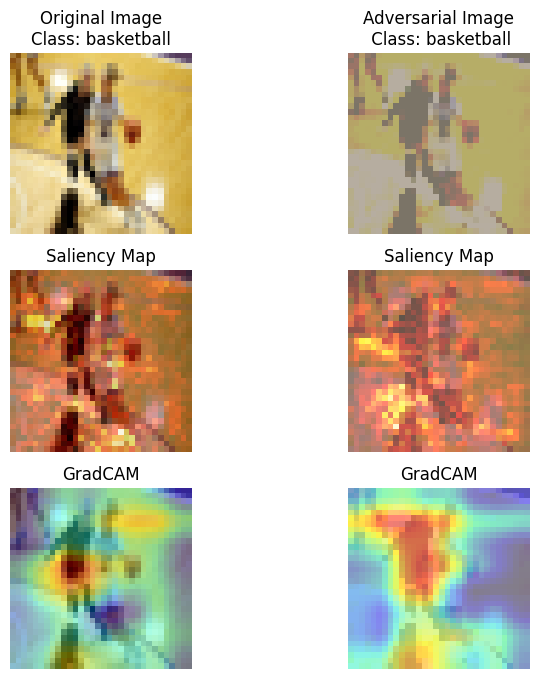

Predicted Logits: -1.3, -0.6, -3.8, -1.7, 3.8, -4.3, 12.2, 1.1, 2.2, -4.3
Mispredicted Logits: -1.4, -2.2, -4.2, -1.1, 0.8, -3.4, 9.2, 2.8, 5.1, -4.1
Perturbation Norm: 39.0149
Attack Successful: False


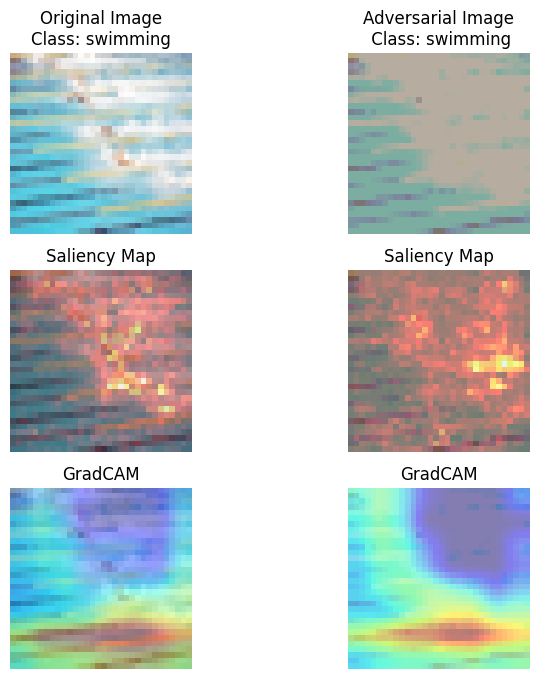

Predicted Logits: 0.3, 1.4, 0.6, -2.2, -2.8, 2.6, -2.9, -0.2, 0.7, 2.6
Mispredicted Logits: 2.5, 0.8, -3.6, -2.7, -3.2, -1.0, 1.0, 1.4, 2.9, 0.8
Perturbation Norm: 35.4938
Attack Successful: True


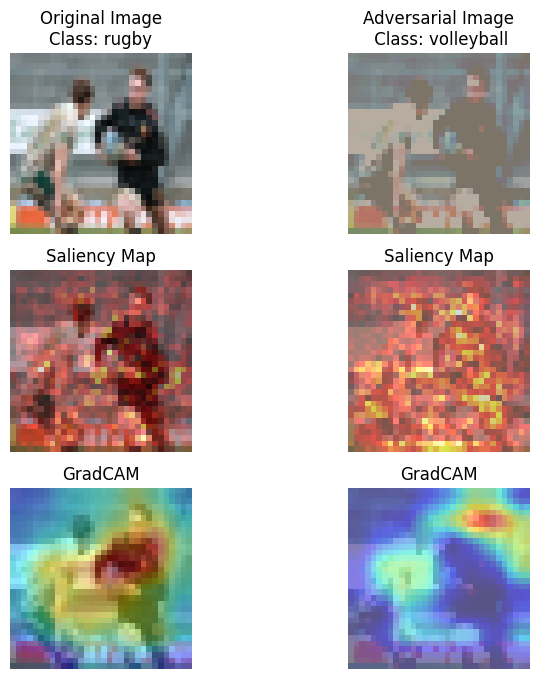

Predicted Logits: -3.6, 2.8, -4.0, -3.6, -3.9, 8.9, 0.7, -2.9, 1.8, 3.6
Mispredicted Logits: 0.8, 0.1, -2.1, -1.5, -2.9, -0.1, 0.2, 1.0, 2.2, 0.4
Perturbation Norm: 52.9749
Attack Successful: True


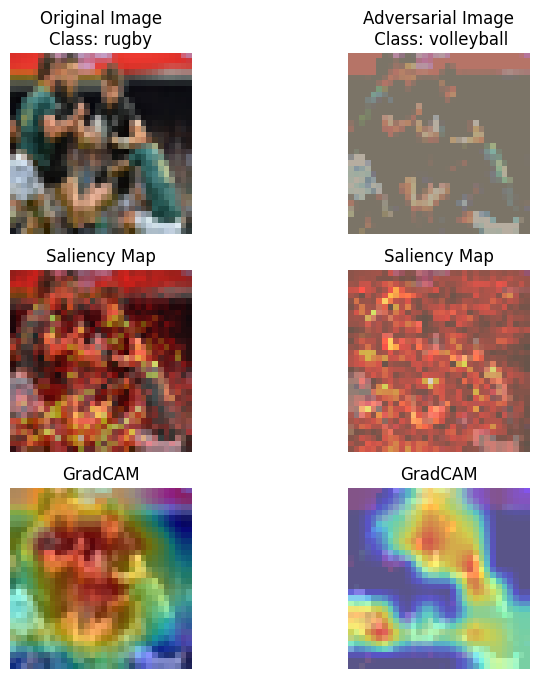

Predicted Logits: -1.9, -0.1, -2.8, -0.6, -3.1, -4.9, 0.1, 6.1, -0.7, 5.9
Mispredicted Logits: -1.4, -0.5, -2.8, -0.5, -2.5, -4.8, 0.1, 7.2, -0.8, 3.7
Perturbation Norm: 17.2837
Attack Successful: False


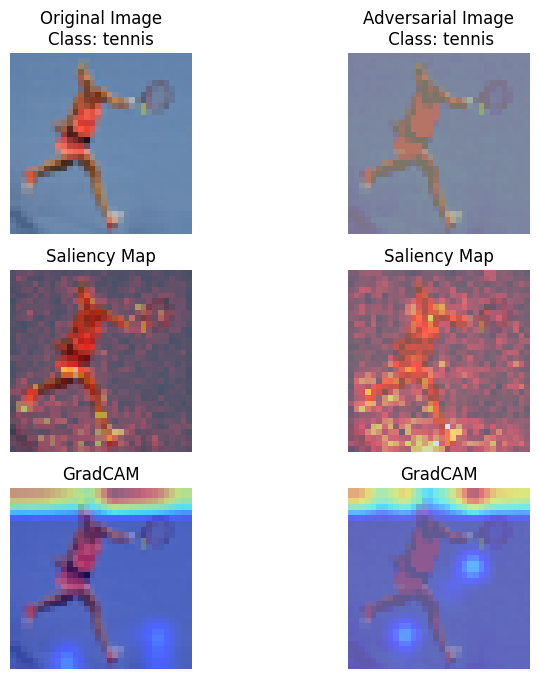

Predicted Logits: -0.8, -0.9, -0.3, 5.9, 5.1, -2.1, 0.4, -2.4, -3.7, 1.3
Mispredicted Logits: -1.0, 0.2, -2.1, 2.4, 3.2, -4.1, -0.1, -0.4, 2.5, 1.0
Perturbation Norm: 53.2746
Attack Successful: True


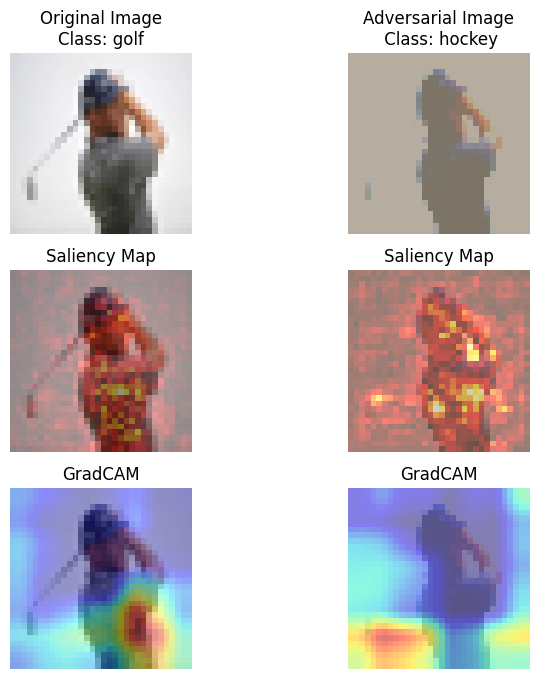

Predicted Logits: -0.4, -0.3, -1.0, -3.3, 1.2, -3.6, 7.7, 0.9, 1.5, -2.0
Mispredicted Logits: 1.0, -2.8, -5.7, -5.0, 2.2, -1.5, 12.3, 0.0, 5.0, -4.0
Perturbation Norm: 43.2746
Attack Successful: False


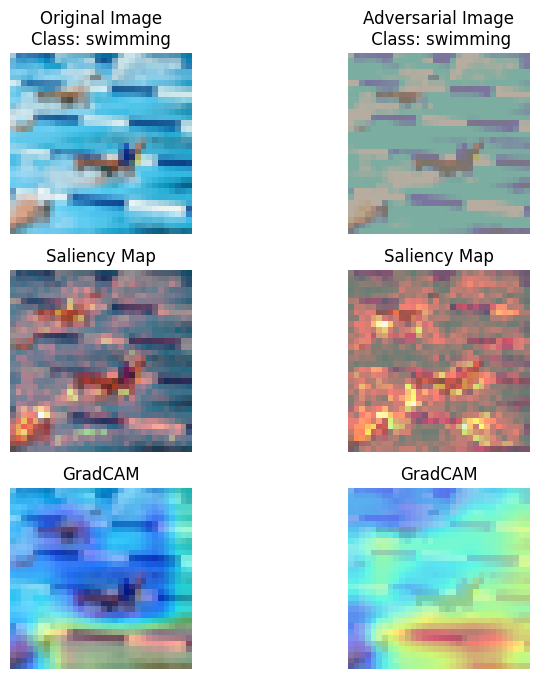

Predicted Logits: 0.2, -3.7, 3.3, 1.3, -6.4, 9.7, -3.0, -1.1, -2.4, -0.5
Mispredicted Logits: 1.5, -2.1, 1.5, -0.9, -4.9, 2.2, 0.1, 0.3, 0.4, -1.7
Perturbation Norm: 44.9173
Attack Successful: False


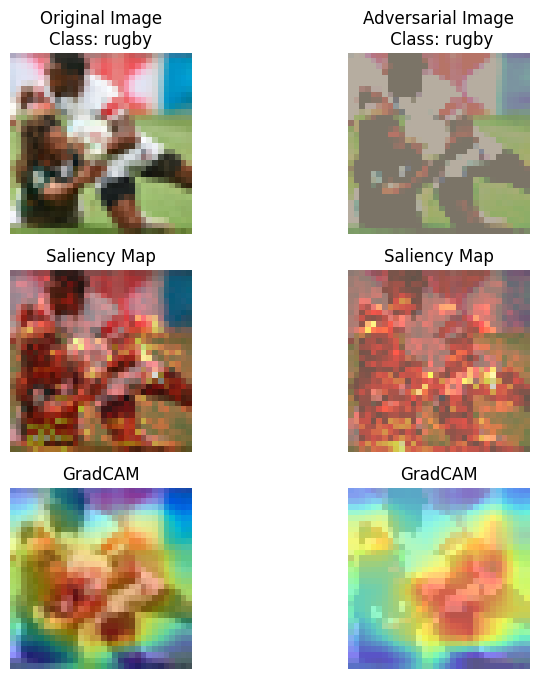

Predicted Logits: -1.7, 4.5, 1.2, -4.2, 1.5, 1.4, -2.9, -4.8, 3.0, -0.9
Mispredicted Logits: 0.1, 3.1, -2.0, -1.9, -0.7, -1.8, -1.2, -0.7, 1.9, 0.4
Perturbation Norm: 52.2015
Attack Successful: False


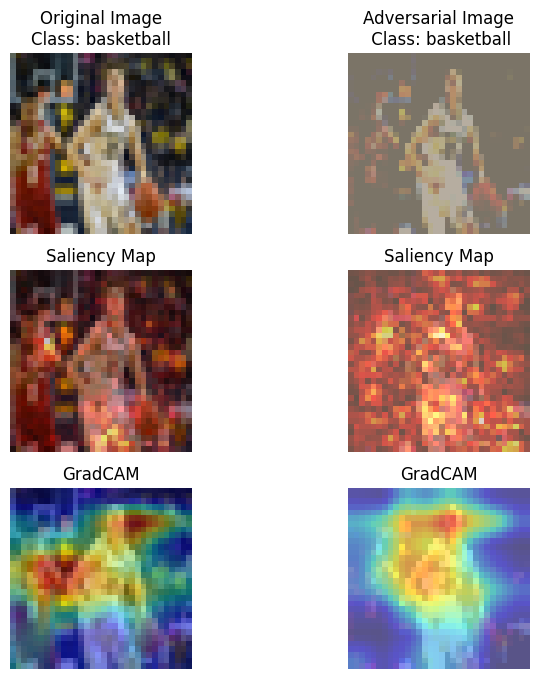

Predicted Logits: -1.1, 2.4, -1.4, -2.0, -3.2, -2.5, -0.1, 3.0, 2.4, 2.5
Mispredicted Logits: 0.4, 0.3, -2.0, -1.1, -2.8, -3.5, 0.4, 4.6, 1.2, 1.6
Perturbation Norm: 47.1020
Attack Successful: False


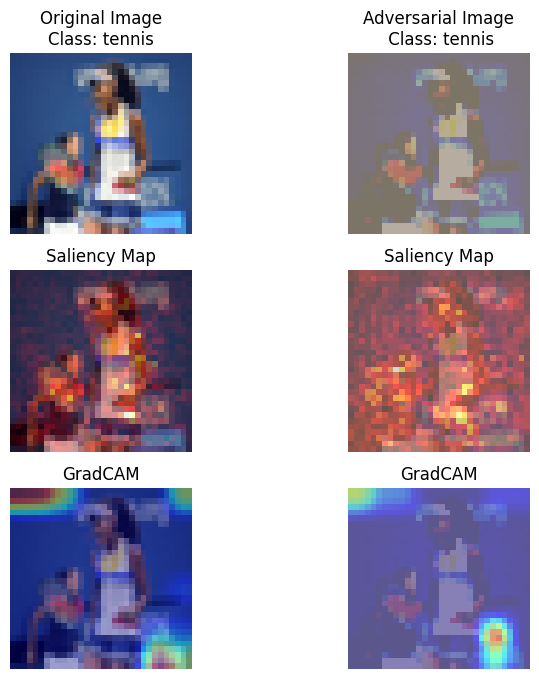

Fast Gradient Sign Method (Targeted to 'basketball'):
Predicted Logits: 0.2, -3.7, 3.3, 1.3, -6.4, 9.7, -3.0, -1.1, -2.4, -0.5
Mispredicted Logits: 1.1, -1.3, 1.1, -1.3, -4.7, 1.5, 0.1, 0.2, 1.0, -1.3
Perturbation Norm: 44.9173
Attack Successful: False


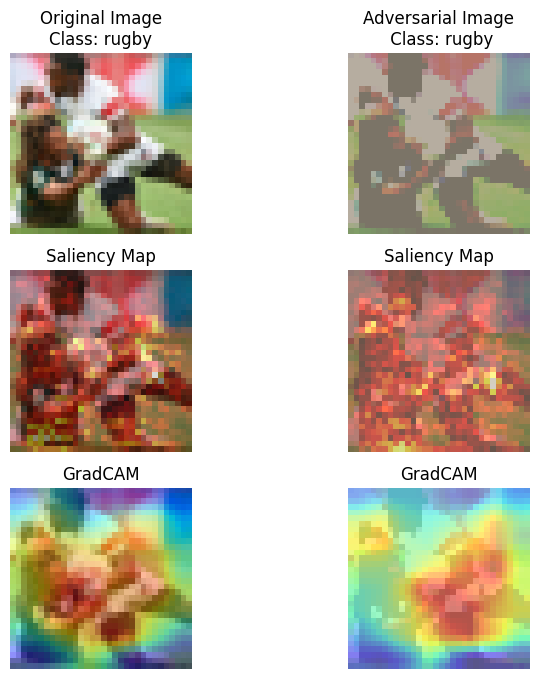

Predicted Logits: -0.7, -0.6, -0.4, -3.5, -1.1, -4.8, -0.5, 4.6, 3.5, 1.8
Mispredicted Logits: 0.5, -2.3, -0.2, 0.1, -1.0, -4.1, -1.8, 5.9, 2.0, -0.8
Perturbation Norm: 42.2917
Attack Successful: False


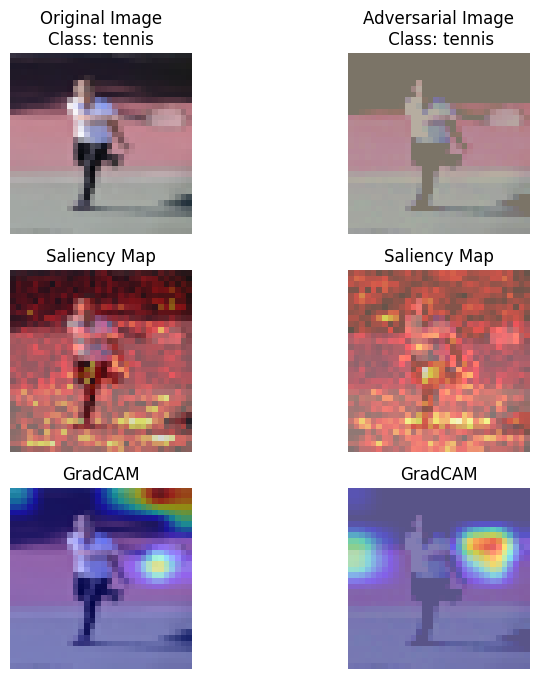

Predicted Logits: 1.0, -0.0, 2.4, -4.1, 3.4, -3.2, -1.7, -2.7, -0.3, 5.0
Mispredicted Logits: -0.4, 0.6, -2.1, -1.9, -1.4, -4.0, 0.5, 2.3, 2.9, 1.8
Perturbation Norm: 35.9558
Attack Successful: False


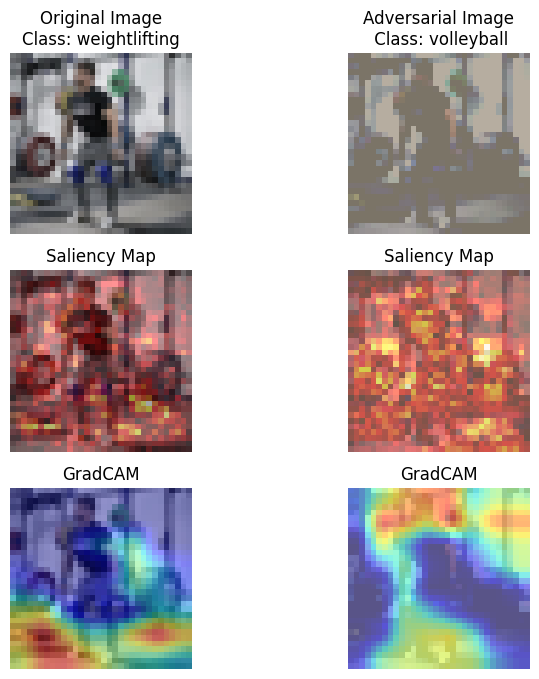

Predicted Logits: 0.2, -0.5, 0.8, -4.0, -2.7, 7.4, -2.1, -1.9, 1.2, -1.6
Mispredicted Logits: 0.7, 0.4, -2.7, -3.2, -1.4, 0.4, 0.7, 0.1, 3.0, -1.1
Perturbation Norm: 56.0874
Attack Successful: False


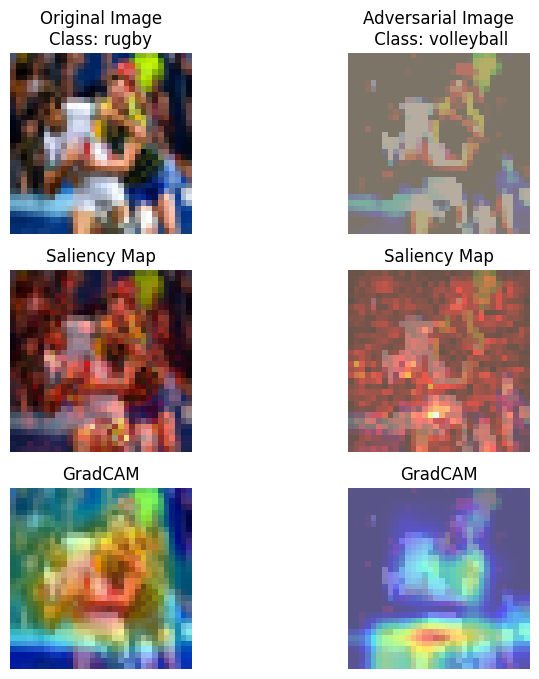

Predicted Logits: -2.0, -2.6, -4.4, -0.6, -1.0, -1.6, 9.9, 3.7, 0.3, -1.2
Mispredicted Logits: 1.5, -1.8, -7.7, -4.5, 0.5, -2.1, 9.3, 1.7, 7.0, -3.4
Perturbation Norm: 37.1302
Attack Successful: False


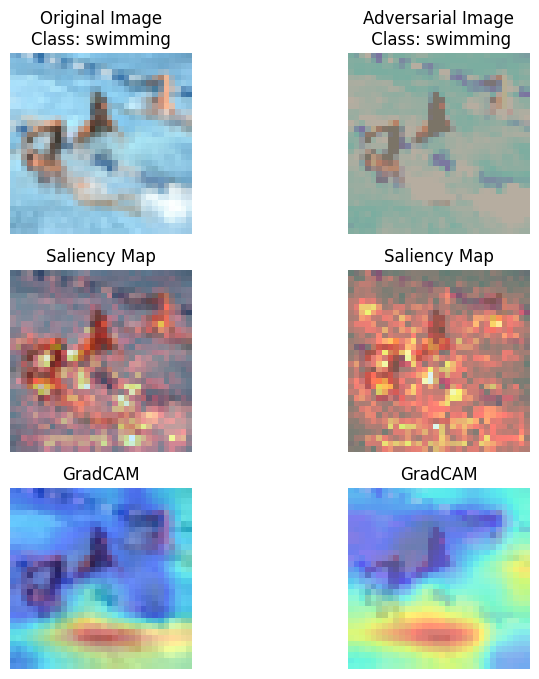

Predicted Logits: -2.8, -1.2, -2.0, -1.5, -0.7, -0.0, 5.6, 0.8, 1.0, 1.0
Mispredicted Logits: -1.7, -1.7, -6.9, -3.4, -1.3, -0.8, 10.3, 1.3, 6.4, -2.1
Perturbation Norm: 39.5960
Attack Successful: False


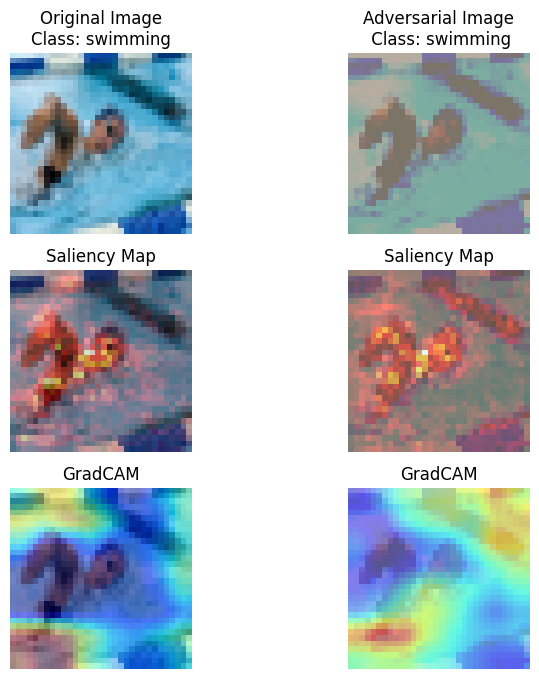

Predicted Logits: -2.0, 1.4, -1.7, -4.4, -3.4, -3.1, -0.4, 0.6, 2.7, 8.7
Mispredicted Logits: 0.1, 0.8, -3.6, -4.5, -3.8, -4.5, 2.0, 3.1, 5.6, 2.4
Perturbation Norm: 39.6126
Attack Successful: False


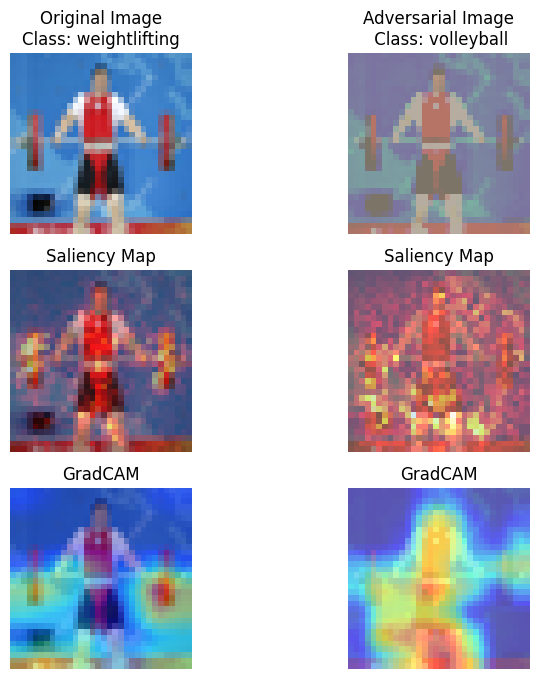

Predicted Logits: -1.4, 2.0, 0.8, -5.1, 7.7, -4.1, -0.7, -2.9, 2.9, -0.4
Mispredicted Logits: -2.7, 2.0, -2.4, -1.7, 3.0, -4.0, 0.2, -0.9, 5.2, 0.5
Perturbation Norm: 50.9127
Attack Successful: False


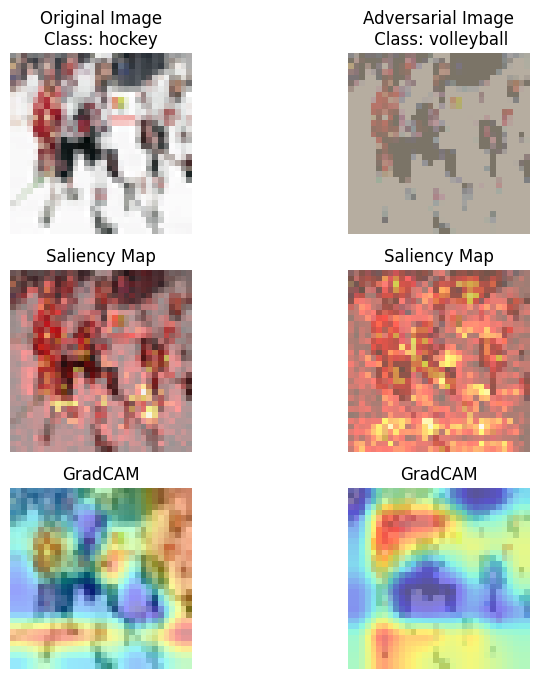

Predicted Logits: 1.3, -2.6, 2.0, 6.5, -1.4, 1.8, -2.5, 2.3, -5.1, -0.9
Mispredicted Logits: 1.6, -0.4, -2.1, 1.2, -0.7, -4.5, -2.6, 3.5, 0.8, 1.3
Perturbation Norm: 50.5646
Attack Successful: False


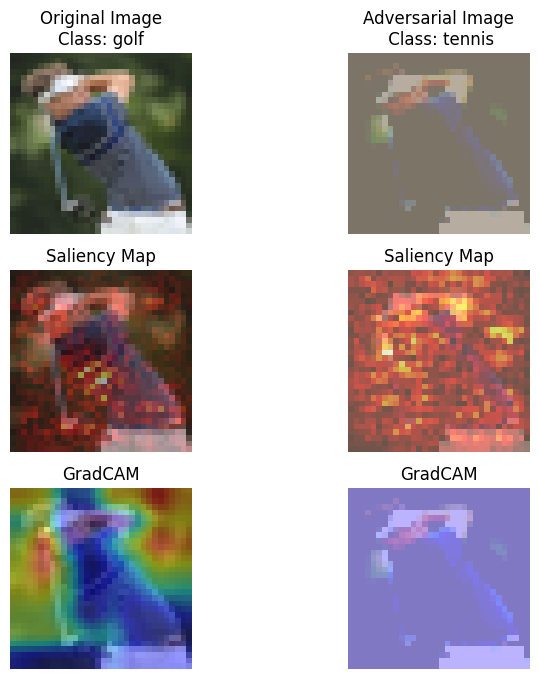

Predicted Logits: -0.3, 2.5, -2.2, -3.5, -1.1, 1.3, -2.9, -1.1, 2.2, 4.2
Mispredicted Logits: 0.3, -0.1, -1.3, -0.2, -2.6, -2.3, -2.5, 3.2, 1.1, 1.3
Perturbation Norm: 46.3138
Attack Successful: False


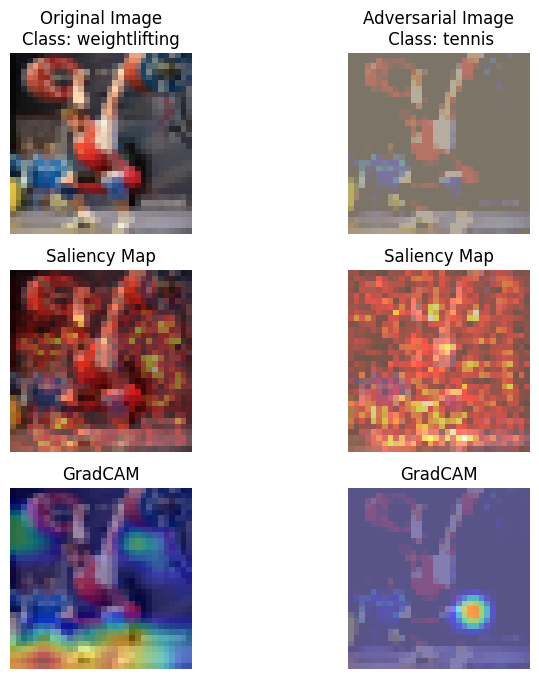

Projected Gradient Descent (Untargeted):
Predicted Logits: -1.8, -0.9, -1.0, 2.4, -2.9, -3.2, 4.6, 5.6, -2.0, -0.2
Mispredicted Logits: -1.1, -1.3, -2.4, 1.8, -3.6, -4.6, 0.9, 7.9, -2.0, 1.3
Perturbation Norm: 48.3258
Attack Successful: False


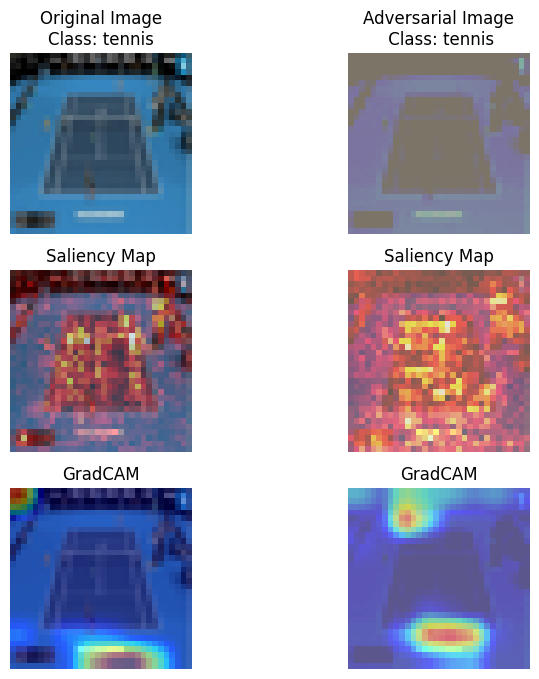

Predicted Logits: -0.5, 1.7, 0.4, -2.4, -1.7, 2.8, -3.7, -1.6, -0.1, 4.8
Mispredicted Logits: 0.7, -1.0, -1.0, 1.7, -1.9, -3.0, -2.1, 3.1, -0.5, 0.9
Perturbation Norm: 81.2244
Attack Successful: True


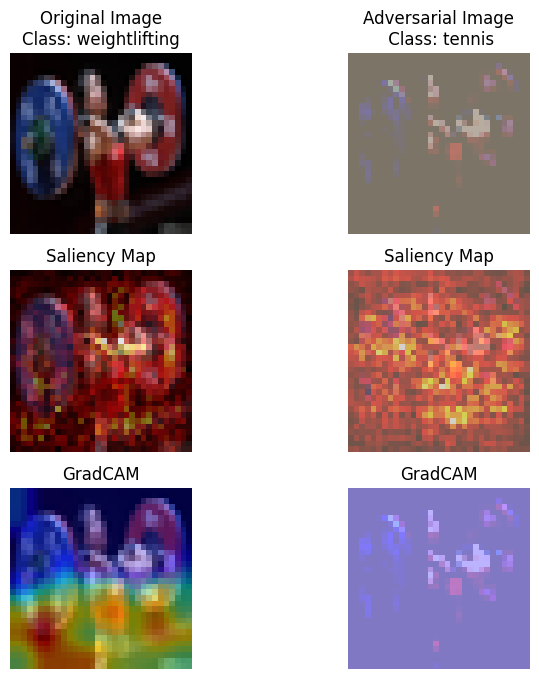

Predicted Logits: -0.7, -0.6, -0.4, -3.5, -1.1, -4.8, -0.5, 4.6, 3.5, 1.8
Mispredicted Logits: 0.4, -3.2, -0.3, 0.5, -1.8, -4.2, -0.8, 7.4, 1.6, -1.5
Perturbation Norm: 42.2901
Attack Successful: False


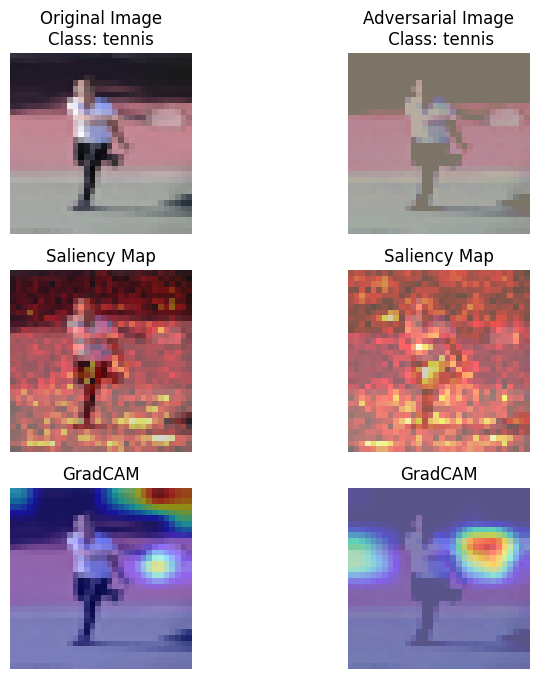

Predicted Logits: -2.0, 1.4, -1.7, -4.4, -3.4, -3.1, -0.4, 0.6, 2.7, 8.7
Mispredicted Logits: -0.3, 0.7, -3.6, -4.6, -3.8, -4.5, 1.7, 3.0, 5.5, 3.2
Perturbation Norm: 39.6116
Attack Successful: True


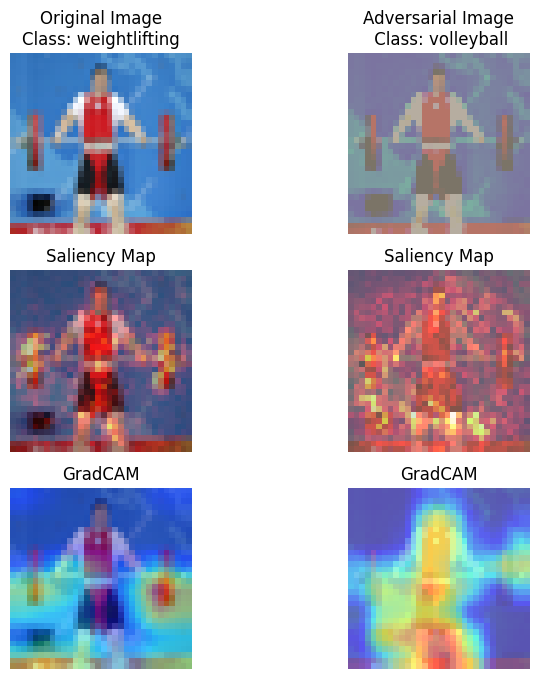

Predicted Logits: -1.4, -0.9, -1.9, -2.3, -0.8, 0.2, -2.4, -3.0, -0.2, 11.5
Mispredicted Logits: 1.3, 0.2, -3.4, -5.1, -4.5, -3.8, 1.4, 3.2, 4.1, 5.0
Perturbation Norm: 47.4976
Attack Successful: False


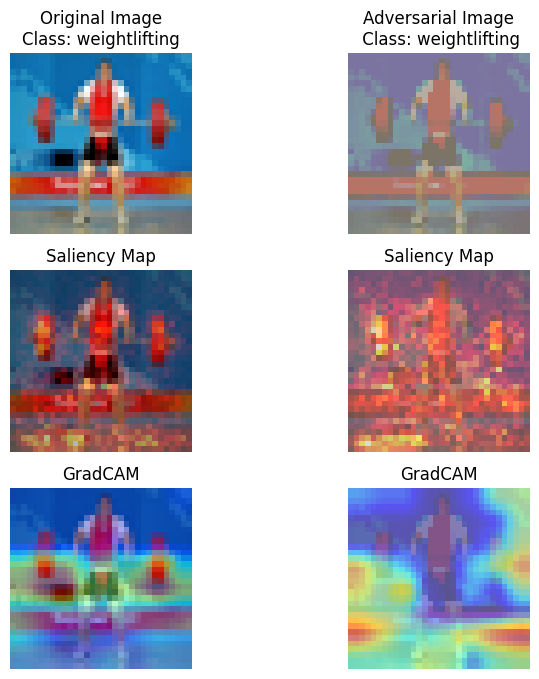

Predicted Logits: -2.0, -2.6, -4.4, -0.6, -1.0, -1.6, 9.9, 3.7, 0.3, -1.2
Mispredicted Logits: 1.8, -2.2, -8.7, -4.6, 0.7, -1.9, 11.0, 1.9, 6.6, -3.9
Perturbation Norm: 37.1294
Attack Successful: False


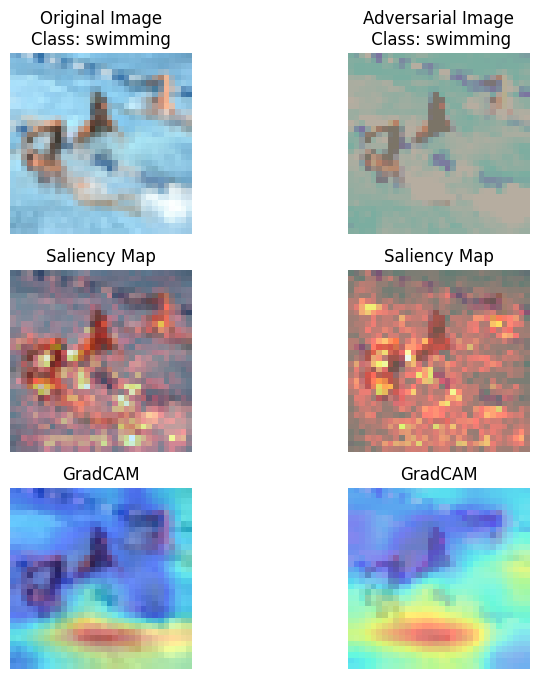

Predicted Logits: -1.3, -0.6, -3.8, -1.7, 3.8, -4.3, 12.2, 1.1, 2.2, -4.3
Mispredicted Logits: -1.5, -2.3, -4.2, -1.0, 0.8, -3.3, 9.5, 2.8, 5.1, -4.2
Perturbation Norm: 39.0147
Attack Successful: False


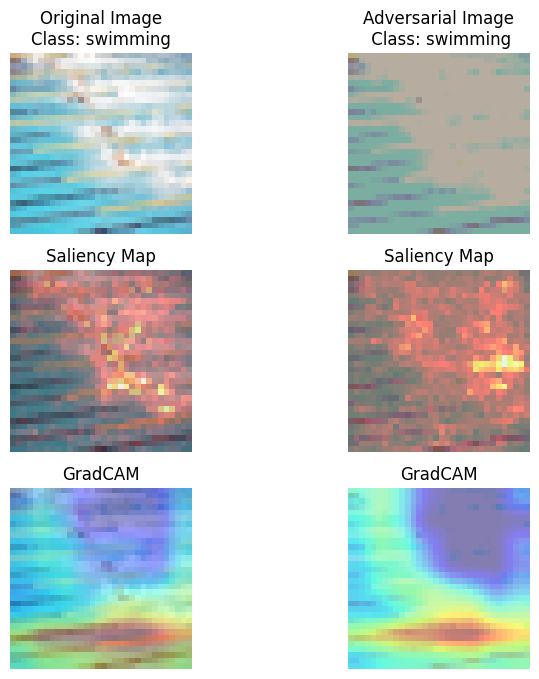

Predicted Logits: 1.0, 0.1, -4.4, 0.1, -5.8, 2.9, 3.2, 4.6, 0.4, -2.5
Mispredicted Logits: 2.9, -3.3, -0.6, 0.2, -1.7, -2.0, 0.3, 3.9, -1.4, -2.1
Perturbation Norm: 65.9851
Attack Successful: False


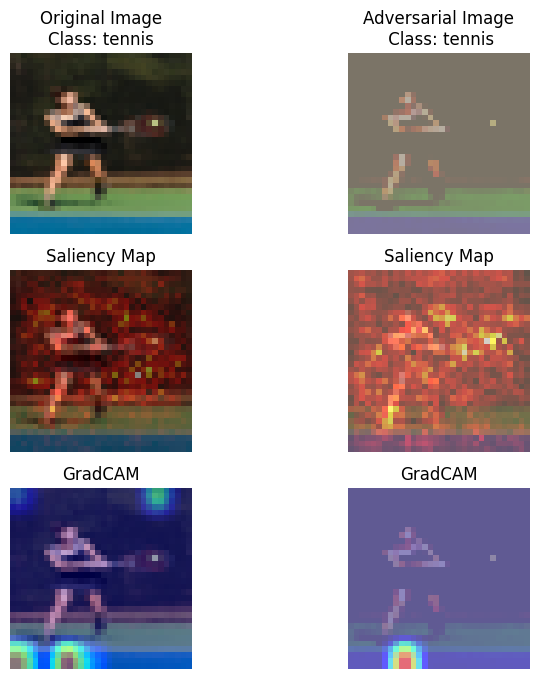

Predicted Logits: 0.2, -3.7, 3.3, 1.3, -6.4, 9.7, -3.0, -1.1, -2.4, -0.5
Mispredicted Logits: 1.5, -2.2, 1.6, -0.9, -5.2, 2.7, 0.0, 0.4, 0.3, -1.7
Perturbation Norm: 44.9166
Attack Successful: False


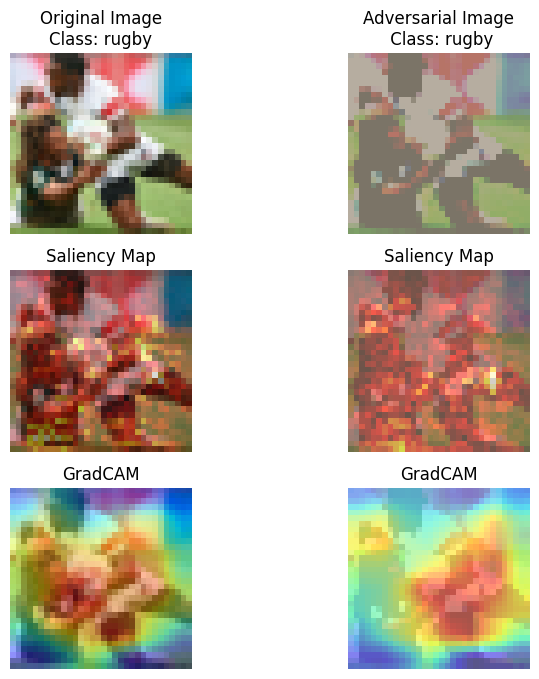

Predicted Logits: -1.2, -2.3, -1.3, -1.9, 1.7, -2.0, 7.3, 0.1, 1.5, 0.1
Mispredicted Logits: -1.3, -4.0, -3.9, -2.9, 0.2, -1.1, 10.5, 1.2, 5.9, -2.9
Perturbation Norm: 46.0847
Attack Successful: False


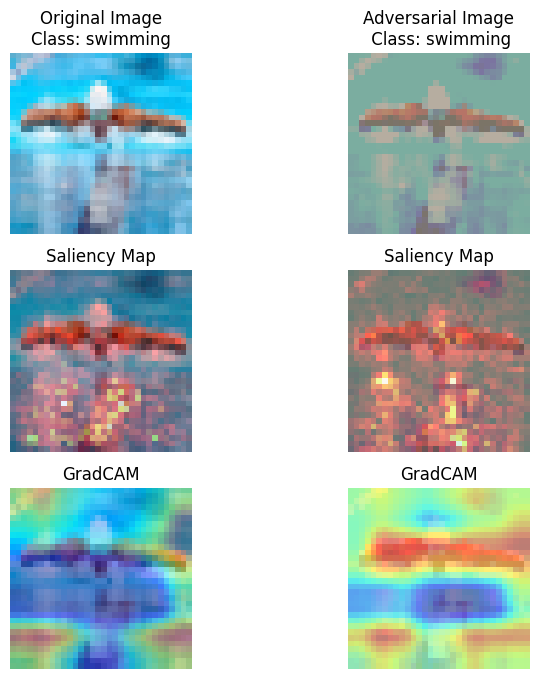

Projected Gradient Descent (Targeted to 'basketball'):
Predicted Logits: 11.4, -3.7, -3.9, -2.7, -1.8, -0.7, 0.2, 3.2, -0.3, -3.4
Mispredicted Logits: 8.0, -2.1, -3.3, -2.4, -1.3, -2.8, -1.2, 3.8, 1.8, -2.0
Perturbation Norm: 26.3414
Attack Successful: False


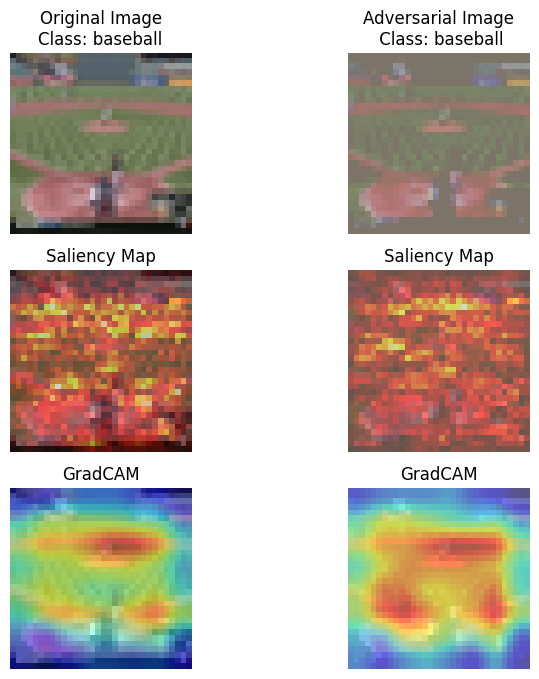

Predicted Logits: 1.0, -5.9, 0.9, 8.0, -4.2, 2.6, 0.6, 2.9, -5.4, -0.5
Mispredicted Logits: 0.4, -1.5, -3.1, 1.0, -3.3, -2.0, 2.2, 3.4, 2.9, -0.2
Perturbation Norm: 51.5636
Attack Successful: False


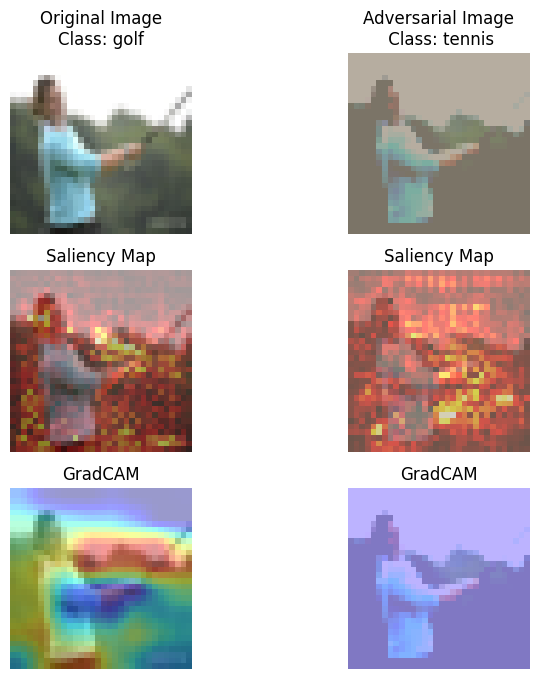

Predicted Logits: -0.5, 1.7, 0.4, -2.4, -1.7, 2.8, -3.7, -1.6, -0.1, 4.8
Mispredicted Logits: 0.8, -0.8, -1.0, 1.5, -1.9, -3.0, -2.1, 3.0, -0.3, 0.7
Perturbation Norm: 81.2244
Attack Successful: False


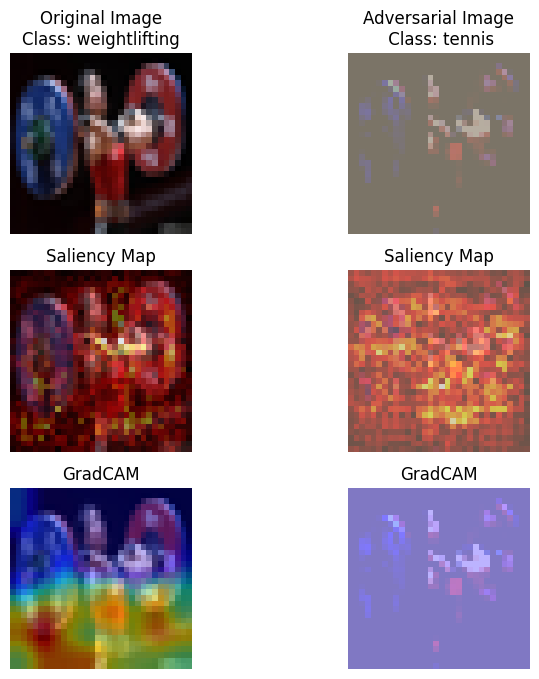

Predicted Logits: -1.4, -0.9, -1.9, -2.3, -0.8, 0.2, -2.4, -3.0, -0.2, 11.5
Mispredicted Logits: 1.7, 0.7, -3.7, -5.3, -4.4, -3.6, 1.5, 2.9, 4.2, 4.4
Perturbation Norm: 47.4977
Attack Successful: False


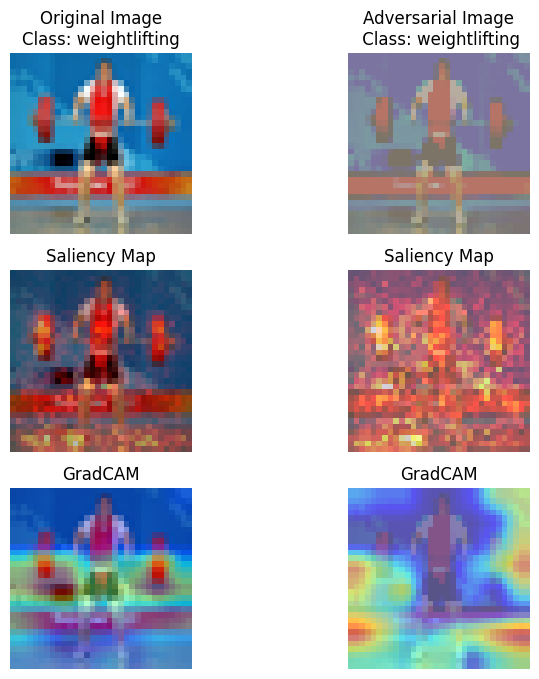

Predicted Logits: 0.2, -0.5, 0.8, -4.0, -2.7, 7.4, -2.1, -1.9, 1.2, -1.6
Mispredicted Logits: 0.6, 0.8, -2.9, -3.3, -1.3, 0.3, 0.6, -0.0, 3.0, -0.9
Perturbation Norm: 56.0872
Attack Successful: False


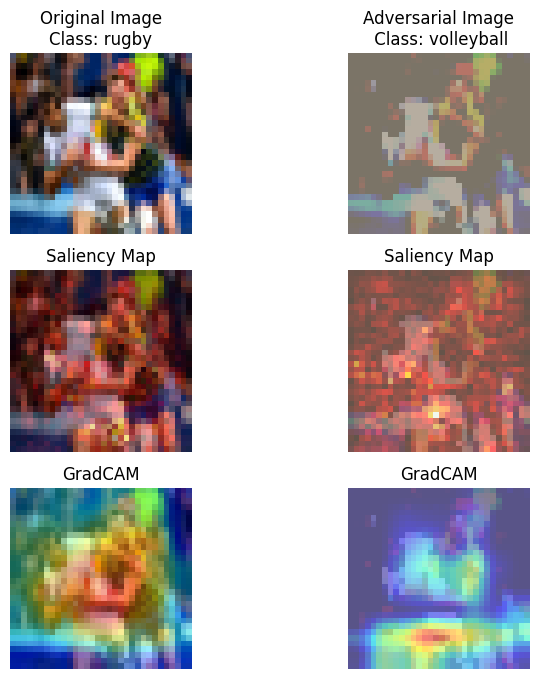

Predicted Logits: 1.0, 0.1, -4.4, 0.1, -5.8, 2.9, 3.2, 4.6, 0.4, -2.5
Mispredicted Logits: 3.0, -2.7, -1.0, -0.2, -1.3, -2.2, 0.5, 3.4, -0.9, -2.1
Perturbation Norm: 65.9851
Attack Successful: False


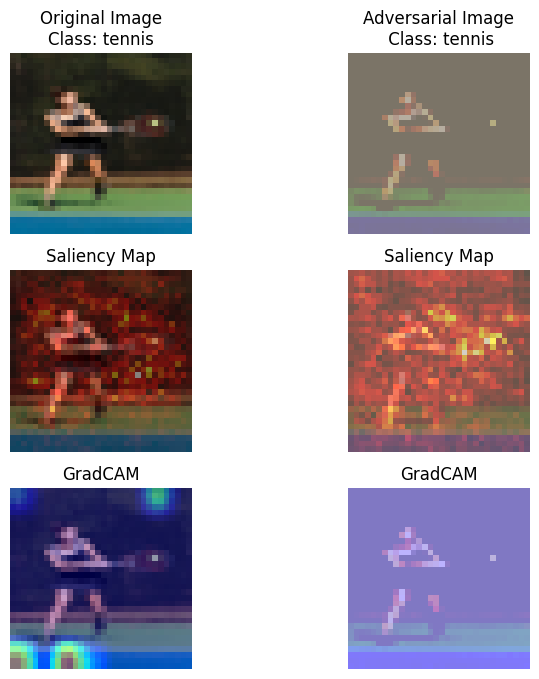

Predicted Logits: -1.8, 3.4, -2.0, -3.3, 9.5, -5.1, 1.5, -2.4, -0.6, 0.3
Mispredicted Logits: -0.5, 3.2, -3.6, -3.0, 5.7, -5.0, -0.5, -1.4, 3.5, 0.6
Perturbation Norm: 57.7578
Attack Successful: False


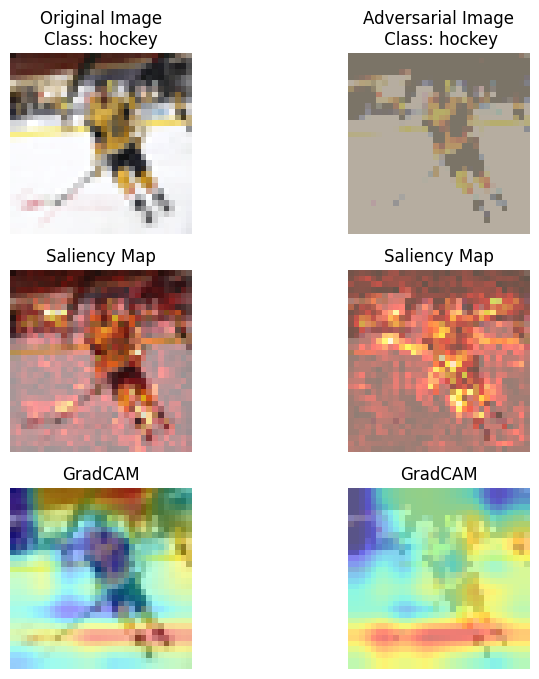

Predicted Logits: -0.4, -2.1, 3.0, 6.8, -3.0, 4.1, -5.3, 1.1, -4.2, -1.8
Mispredicted Logits: 1.8, -1.1, -0.2, 2.3, -4.1, -2.9, -3.5, 5.3, 0.3, -0.4
Perturbation Norm: 56.6818
Attack Successful: False


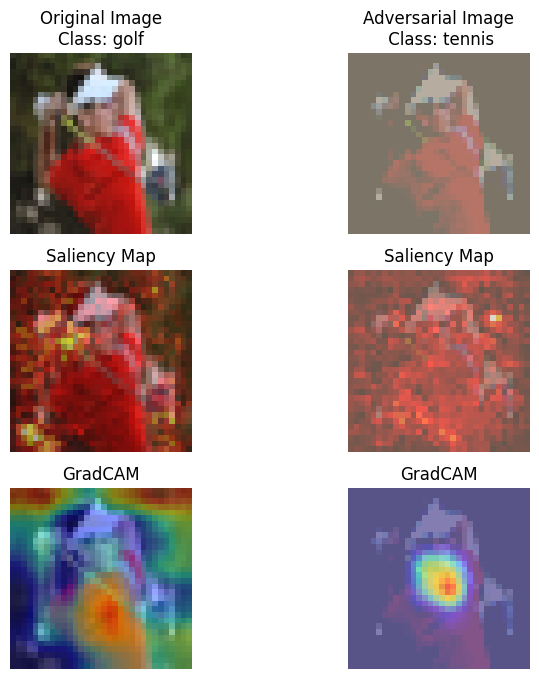

Predicted Logits: 4.1, 0.1, 1.4, -0.1, 0.3, -0.9, -1.8, 0.4, -1.0, -0.6
Mispredicted Logits: 2.4, 0.1, -1.8, 0.8, -0.8, -3.6, -1.7, 2.6, 0.3, -0.1
Perturbation Norm: 65.4407
Attack Successful: False


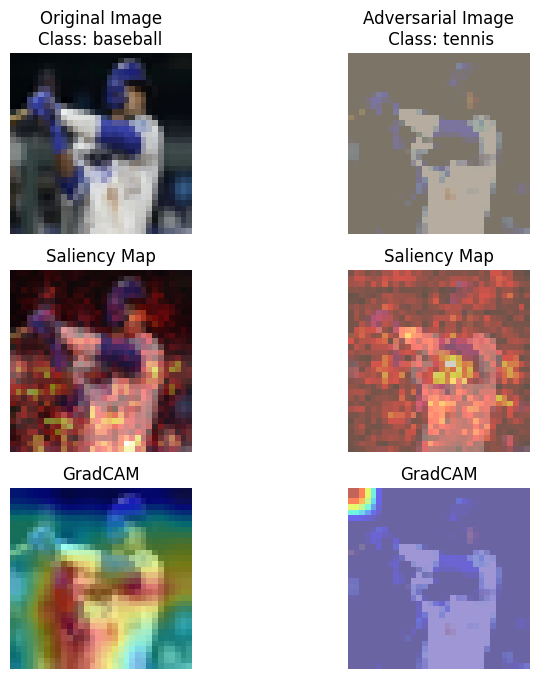

Predicted Logits: 1.0, -0.0, 2.4, -4.1, 3.4, -3.2, -1.7, -2.7, -0.3, 5.0
Mispredicted Logits: -0.3, 1.3, -2.6, -2.6, -1.1, -4.1, 0.7, 1.8, 3.3, 1.8
Perturbation Norm: 35.9551
Attack Successful: False


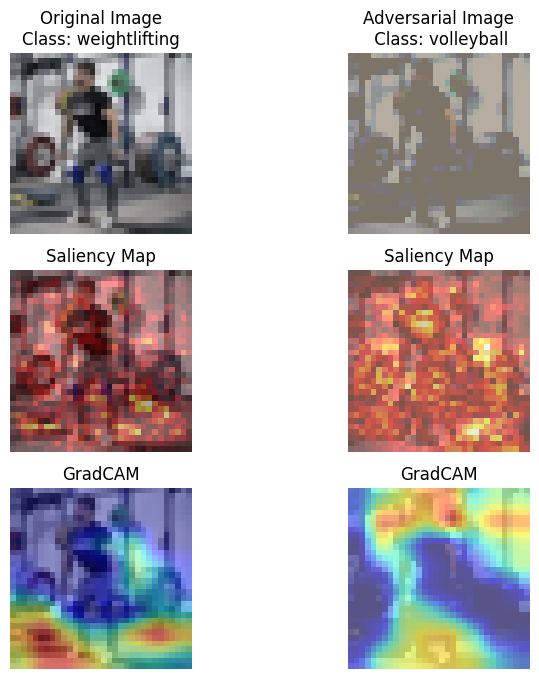

In [5]:
from models import CNNModel, MultiLayerPerceptron, test_loader
from matplotlib import pyplot as plt

def logits_to_string(logits):
	return ', '.join([f'{logits[0, i]:.1f}' for i in range(len(classes))])

def generate_samples(model, attack_method, gradcam, target_class=None, num_samples=10):
	model.eval()

	samples_left = num_samples
	samples = []

	for images, labels in test_loader:
		for i in range(len(images)):
			if samples_left <= 0:
				return samples

			image = images[i]
			label = labels[i].item()

			if target_class is not None and label == target_class:
				continue

			logits = model(image.unsqueeze(0))
			predicted_class = logits.argmax(dim=1).item()

			# ignore if already misclassified
			if predicted_class != label:
				continue

			samples_left -= 1

			adversarial_image = attack_method(model, image, target_class=target_class)
			pert_norm = pertubation_norm(image, adversarial_image)

			_, axis = plt.subplots(3, 2, figsize=(8, 8), squeeze=True)

			axis[0, 0].imshow(unnormalize(image).permute(1, 2, 0).cpu())
			axis[0, 0].set_title(f"Original Image\nClass: {classes[label]}")
			axis[0, 0].axis('off')

			predicted_logits = model(adversarial_image.unsqueeze(0))
			predicted_class = predicted_logits.argmax(dim=1).item()

			axis[0, 1].imshow(unnormalize(adversarial_image).permute(1, 2, 0).cpu())
			axis[0, 1].set_title(f"Adversarial Image\n Class: {classes[predicted_class]}")
			axis[0, 1].axis('off')

			print(f'Predicted Logits: {logits_to_string(logits)}')
			print(f'Mispredicted Logits: {logits_to_string(predicted_logits)}')
			print(f'Perturbation Norm: {pert_norm:.4f}')

			success = (predicted_class != label) if target_class is None else (predicted_class == target_class)
			print(f'Attack Successful: {success}')

			saliency_img, gradcam_img = interpret_image(model, image, gradcam)
			axis[1, 0].imshow(saliency_img)
			axis[1, 0].set_title("Saliency Map")
			axis[1, 0].axis('off')

			axis[2, 0].imshow(gradcam_img)
			axis[2, 0].set_title("GradCAM")
			axis[2, 0].axis('off')

			saliency_img_adv, gradcam_img_adv = interpret_image(model, adversarial_image, gradcam)
			axis[1, 1].imshow(saliency_img_adv)
			axis[1, 1].set_title("Saliency Map")
			axis[1, 1].axis('off')

			axis[2, 1].imshow(gradcam_img_adv)
			axis[2, 1].set_title("GradCAM")
			axis[2, 1].axis('off')

			plt.show()

			samples.append((image, adversarial_image, label))

	return samples

basketball_label = classes.index('basketball')

cnn_model = CNNModel()
cnn_model.load("checkpoints/cnn-original.pt")

gradcam = GradCAM(cnn_model, cnn_model.features[14])

print("Fast Gradient Sign Method (Untargeted):")
fgsm_untargeted = generate_samples(cnn_model, FastGradientSignMethod, gradcam)
print("Fast Gradient Sign Method (Targeted to 'basketball'):")
fgsm_targeted = generate_samples(cnn_model, FastGradientSignMethod, gradcam, target_class=basketball_label)
print("Projected Gradient Descent (Untargeted):")
pgd_untargeted = generate_samples(cnn_model, ProjectedGradientDescent, gradcam)
print("Projected Gradient Descent (Targeted to 'basketball'):")
pgd_targeted = generate_samples(cnn_model, ProjectedGradientDescent, gradcam, target_class=basketball_label)

In [6]:
from models import MultiLayerPerceptron

mlp_model = MultiLayerPerceptron()
mlp_model.load("checkpoints/mlp-original.pt")

def analyze_transferability(model, samples, target_class=None):
	model.eval()

	success_count = 0

	pertubation_norms = []
	confidence_scores = []

	for original_image, adversarial_image, correct_label in samples:
		logits = model(adversarial_image.unsqueeze(0))

		predicted_label = logits.argmax(dim=1).item()

		pert_norm = pertubation_norm(original_image, adversarial_image)
		pertubation_norms.append(pert_norm)

		confidence_label = predicted_label if target_class is None else target_class

		confidence_score = torch.softmax(logits, dim=1)[0, confidence_label].item()
		confidence_scores.append(confidence_score)

		if target_class is None:
			if predicted_label != correct_label:
				success_count += 1
		else:
			if predicted_label == target_class:
				success_count += 1

	return f'Successful: {success_count}, Average Perturbation Norm: {sum(pertubation_norms)/len(pertubation_norms):.2f}, Average Confidence Score: {100*sum(confidence_scores)/len(confidence_scores):.2f}%'

print("Analyzing Attack Success on CNN Model:")
print(f'FGSM Untargeted: {analyze_transferability(cnn_model, fgsm_untargeted)}')
print(f'FGSM Targeted to "basketball": {analyze_transferability(cnn_model, fgsm_targeted, basketball_label)}')
print(f'PGD Untargeted: {analyze_transferability(cnn_model, pgd_untargeted)}')
print(f'PGD Targeted to "basketball": {analyze_transferability(cnn_model, pgd_targeted, basketball_label)}')

for sparsity in [20, 50, 80]:
	pruned_model = CNNModel()
	pruned_model.load(f"checkpoints/cnn-fine-tuned-{sparsity}%.pt")

	print(f"\nAnalyzing Attack Success on Pruned CNN Model ({sparsity}%):")
	print(f'FGSM Untargeted: {analyze_transferability(pruned_model, fgsm_untargeted)}')
	print(f'FGSM Targeted to "basketball": {analyze_transferability(pruned_model, fgsm_targeted, basketball_label)}')
	print(f'PGD Untargeted: {analyze_transferability(pruned_model, pgd_untargeted)}')
	print(f'PGD Targeted to "basketball": {analyze_transferability(pruned_model, pgd_targeted, basketball_label)}')

print("\nAnalyzing Transferability to MLP Model:")

print(f'FGSM Untargeted: {analyze_transferability(mlp_model, fgsm_untargeted)}')
print(f'FGSM Targeted to "basketball": {analyze_transferability(mlp_model, fgsm_targeted, basketball_label)}')
print(f'PGD Untargeted: {analyze_transferability(mlp_model, pgd_untargeted)}')
print(f'PGD Targeted to "basketball": {analyze_transferability(mlp_model, pgd_targeted, basketball_label)}')

Analyzing Attack Success on CNN Model:
FGSM Untargeted: Successful: 3, Average Perturbation Norm: 42.33, Average Confidence Score: 68.89%
FGSM Targeted to "basketball": Successful: 0, Average Perturbation Norm: 44.34, Average Confidence Score: 1.95%
PGD Untargeted: Successful: 2, Average Perturbation Norm: 49.21, Average Confidence Score: 82.59%
PGD Targeted to "basketball": Successful: 0, Average Perturbation Norm: 54.45, Average Confidence Score: 2.90%

Analyzing Attack Success on Pruned CNN Model (20%):
FGSM Untargeted: Successful: 5, Average Perturbation Norm: 42.33, Average Confidence Score: 80.24%
FGSM Targeted to "basketball": Successful: 0, Average Perturbation Norm: 44.34, Average Confidence Score: 1.59%
PGD Untargeted: Successful: 5, Average Perturbation Norm: 49.21, Average Confidence Score: 78.70%
PGD Targeted to "basketball": Successful: 1, Average Perturbation Norm: 54.45, Average Confidence Score: 4.04%

Analyzing Attack Success on Pruned CNN Model (50%):
FGSM Untargeted